In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("../..")
%matplotlib inline

In [2]:
from processor.preprocessors import data_split
from trading_env.env_cryptotrading_stable_baselines3 import CryptoTradingEnv
from agent.models import DRLAgent
from config import (
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    VALID_2_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from stable_baselines3.common.logger import configure

In [3]:
processed_dts10_add_tech = pd.read_csv("../../dataset/hour-level/crypto_TI_t10_2023-04-01.csv")

In [4]:
state_interval = 5
TEST_START_DATE = pd.to_datetime(TEST_START_DATE)
TEST_START_DATE = TEST_START_DATE - pd.Timedelta(hours=state_interval - 1)
TEST_START_DATE = TEST_START_DATE.strftime('%Y-%m-%d %H:%M:%S')

In [5]:
train = data_split(processed_dts10_add_tech, TRAIN_START_DATE, VALID_2_END_DATE)
valid = data_split(processed_dts10_add_tech, TEST_START_DATE, TEST_END_DATE)

print(len(train))
print(len(valid))


175190
21640


In [6]:
crypto_tic_dim = len(train.tic.unique())
# state_space_dim = 1 + 2*crypto_tic_dim + len(INDICATORS)*crypto_tic_dim
state_space_dim = 1 + (state_interval * 5 + 1) * crypto_tic_dim
print(f"Stock Dimension: {crypto_tic_dim}, State Space: {state_space_dim}")

Stock Dimension: 10, State Space: 261


## Agents

### PPO

In [7]:
buy_cost_list = sell_cost_list = [0.001] * crypto_tic_dim
num_stock_shares = [0] * crypto_tic_dim

env_kwargs_train = {
    "cash": 100000,
    "action_scaling": 1/10,
    "num_crypto_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space_dim": state_space_dim,
    "crypto_dim": crypto_tic_dim,
    "action_space_dim": crypto_tic_dim,
    "print_verbosity": 5,
    "eval_time_interval": 30 * 24,
    "is_debug": True,
    "risk_control": True,
    "model_name": "ppo_hour_level",
    "data_granularity": 24,
    "state_interval": state_interval
}
env_kwargs_test = env_kwargs_train.copy()
env_kwargs_test["is_debug"] = False

In [8]:
e_train_gym = CryptoTradingEnv(df = train, **env_kwargs_train)
e_valid_gym = CryptoTradingEnv(df = valid, **env_kwargs_test)

In [9]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.001,
    "batch_size": 256
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS, seed=42)
# set up logger
tmp_path = RESULTS_DIR + '/ppo_hour_level'
new_logger_ppo = configure(tmp_path, ["csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.001, 'batch_size': 256}
Using cuda device


In [ ]:
final = []
iterations = 30
max_account_value = 0

for i in range(iterations):
    # train model
    trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=100000)
    df_account_value_ppo, df_actionppo, df_valid_actionppo, df_stateppo = DRLAgent.DRL_prediction(model=trained_ppo, environment=e_valid_gym)
    res = df_account_value_ppo["portfolio_value"][len(df_account_value_ppo)-1]
    final.append(df_account_value_ppo["portfolio_value"])
    df_account_value_ppo.to_csv(f"../../plot/dataset/ppo_hourly_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_new_reward.csv")
    trained_ppo.save(f"../../model_saves/ppo_hourly_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_new_reward")


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 5
begin_portfolio_value:	 99982.55
end_portfolio_value:	 527.01
total_profits:		 -99455.54
total_buy_cost:		 152584.91
total_sell_cost:	 152790.29
total_buy_trades:	 46375
total_sell_trades:	 53858

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 10
begin_portfolio_value:	 99958.95
end_portfolio_value:	 418.70
total_profits:		 -99540.25
total_buy_cost:		 199675.15
total_sell_cost:	 199974.80
total_buy_trades:	 47093
total_sell_trades:	 53104

episode:		 5
begin_portfolio_value:	 99980.67
end_portfolio_value:	 93618.36
total_profits:		 -6362.31
total_buy_cost:		 13736.04
total_sell_cost:	 13663.44
total_buy_trades:	 3367
total_sell_trades:	 3815

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 15
begin_portfolio_value:	 99951.59
end_portfolio_value:	 369.07
total_profits:		 -99582.53
total_buy_cost:		 194000.33
total_sell_cost:	 194288.62
total_buy_trades:	 42352
total_sell_trades:	 47280

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 20
begin_portfolio_value:	 99982.13
end_portfolio_value:	 511.97
total_profits:		 -99470.16
total_buy_cost:		 126547.87
total_sell_cost:	 126701.12
total_buy_trades:	 37782
total_sell_trades:	 42145

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 30
begin_portfolio_value:	 99952.05
end_portfolio_value:	 455.08
total_profits:		 -99496.97
total_buy_cost:		 159224.41
total_sell_cost:	 159443.08
total_buy_trades:	 37569
total_sell_trades:	 40940

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 35
begin_portfolio_value:	 99964.79
end_portfolio_value:	 99.59
total_profits:		 -99865.20
total_buy_cost:		 79907.67
total_sell_cost:	 79967.54
total_buy_trades:	 37006
total_sell_trades:	 40097

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 40
begin_portfolio_value:	 99954.01
end_portfolio_value:	 510.23
total_profits:		 -99443.78
total_buy_cost:		 103344.84
total_sell_cost:	 103451.64
total_buy_trades:	 34213
total_sell_trades:	 36683

episode:		 20
begin_portfolio_value:	 99951.40
end_portfolio_value:	 95316.68
total_profits:		 -4634.72
total_buy_cost:		 7004.90
total_sell_cost:	 6918.82
total_buy_trades:	 1337
total_sell_trades:	 1447

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 45
begin_portfolio_value:	 99959.27
end_portfolio_value:	 177.22
total_profits:		 -99782.05
total_buy_cost:		 101295.86
total_sell_cost:	 101398.56
total_buy_trades:	 39841
total_sell_trades:	 43314

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 50
begin_portfolio_value:	 99957.37
end_portfolio_value:	 218.88
total_profits:		 -99738.49
total_buy_cost:		 104324.90
total_sell_cost:	 104433.66
total_buy_trades:	 38232
total_sell_trades:	 41137

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

# Backtesting results

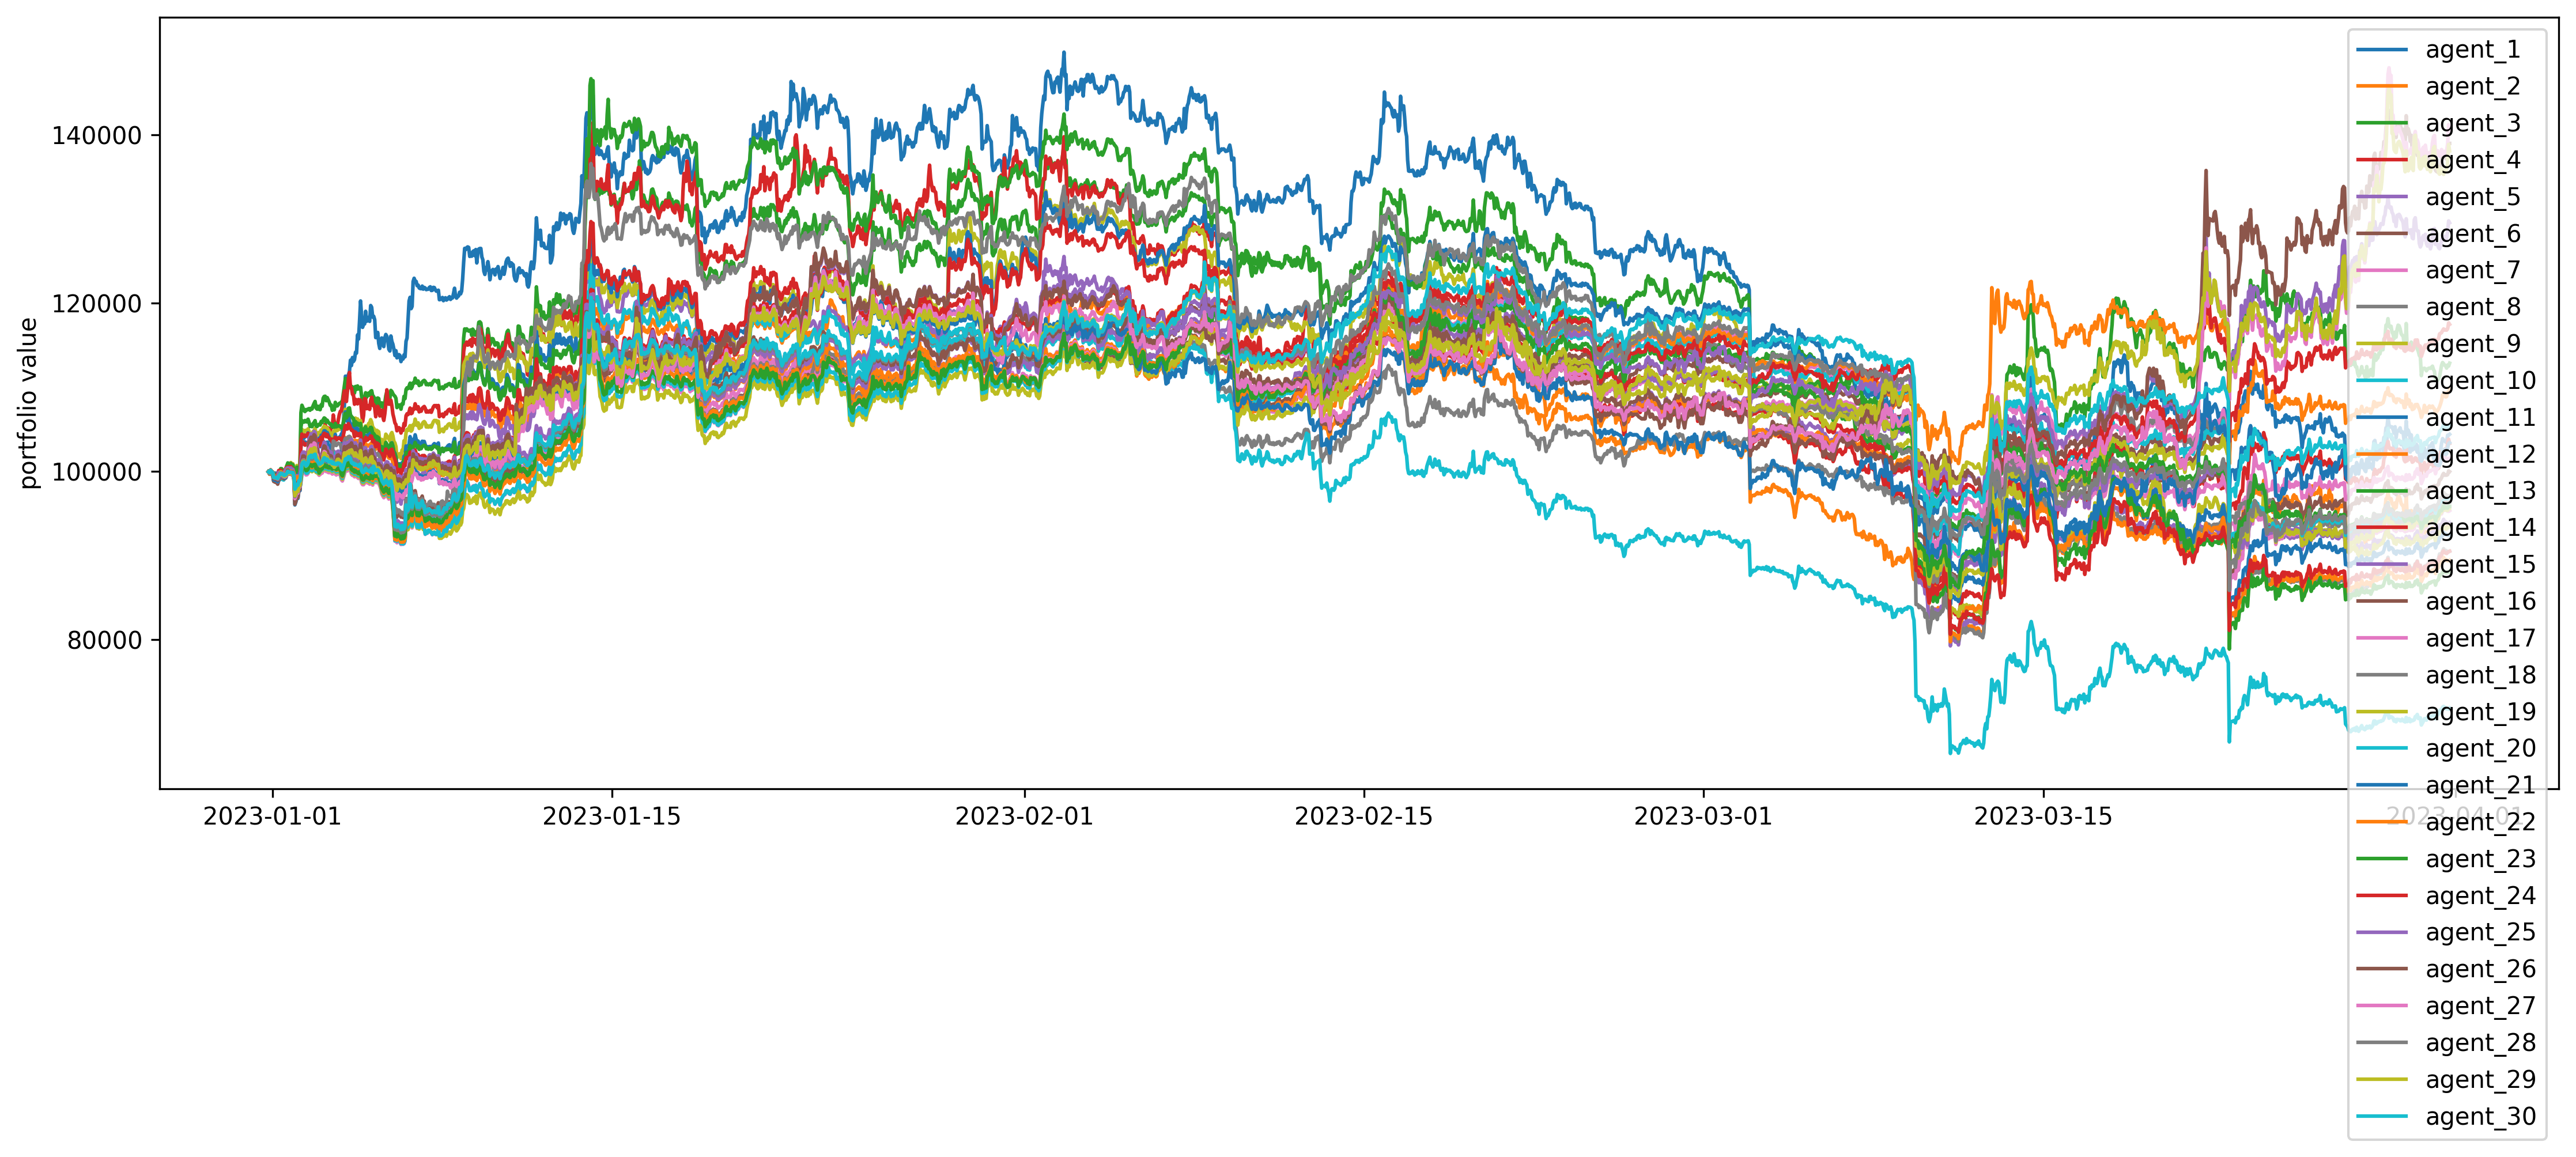

In [13]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["figure.dpi"] = 300
plt.figure()

x = df_account_value_ppo["timestamp"]
x = pd.to_datetime(x)
s = 1
for i in final:
    plt.plot(x,i,label=f'agent_{s}')
    s+=1
plt.ylabel("portfolio value")
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig("../../plot/test_plot/ppo_hourly_stack_frame/stack_5_hour_test_default_ppo_act_0.1_seed_42_new_reward.png", dpi=300)
plt.show()

In [15]:
df = pd.DataFrame(data = x)
s = 1
for i in final:
    df[f"round_{s}"] = i
    s += 1
df.to_csv("stack_5_hourly_test_default_ppo_act_0.1_seed_42_new_reward.csv")